In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import catboost as cat
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv("../../datasets/coffee_shop_dataset/coffee_shop_revenue.csv")
target = "Daily_Revenue"

num_features = list(df.select_dtypes(exclude='object'))
num_features.remove(target)
cat_features = list(df.select_dtypes(include='object'))
catboost_features = num_features+cat_features

# Dataset preprocessing

In [4]:
df.loc[:, num_features] = df.loc[:, num_features].fillna(0)
df.loc[:, cat_features] = df.loc[:, cat_features].fillna('Other')

In [5]:
enc = OneHotEncoder(sparse_output=False, drop='first')
encoded_cat_df = enc.fit_transform(df[cat_features])
encoded_cat_df = pd.DataFrame(encoded_cat_df, columns=enc.get_feature_names_out(cat_features)).astype('Int16')
encoded_cat_features = list(encoded_cat_df.columns)
encoded_cat_df.shape

(2000, 0)

In [6]:
encoded_df = pd.concat([df, encoded_cat_df], axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    encoded_df[num_features+cat_features+encoded_cat_features], 
    encoded_df[target], 
    test_size=0.33, random_state=2025)

df_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
df_test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [8]:
linear_features = num_features+encoded_cat_features

In [9]:
scaler = MinMaxScaler()
scaled_df_train = scaler.fit_transform(df_train[linear_features])
scaled_df_train = pd.DataFrame(scaled_df_train, columns=linear_features)
scaled_df_train = pd.concat([scaled_df_train, df_train[[target]+ cat_features]], axis=1)

scaled_df_test = scaler.transform(df_test[linear_features])
scaled_df_test = pd.DataFrame(scaled_df_test, columns=linear_features)
scaled_df_test = pd.concat([scaled_df_test, df_test[[target]+ cat_features]], axis=1)

# Simple Linear Regression

In [10]:
result_metrics = pd.DataFrame(columns=[
     'algorithm',
     'dataset_type',
     'R2',
     'MSE',
     'RMSE',
     'MAE',
     'MAPE'
])

In [11]:
def get_metrics(y_true, y_pred, algorithm, dataset_type, res_df=None):
    res_df = res_df.copy()
    
    r2 = metrics.r2_score(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mape = metrics.mean_absolute_percentage_error(y_true, y_pred)

    print(f"{algorithm}, -- Type Dataset - {dataset_type}")
    print(f"R2 = {r2}")
    print(f"MSE = {mse}")
    print(f"RMSE = {mse**0.5}")
    print(f"MAE = {mae}")
    print(f"MAPE = {mape}")
    
    curr_res = [algorithm, dataset_type] + [r2, mse, mse**0.5, mae, mape]
    res_df = pd.concat([res_df,
                        pd.DataFrame([curr_res], columns=['algorithm',
                                                            'dataset_type',
                                                            'R2',
                                                            'MSE',
                                                            'RMSE',
                                                            'MAE',
                                                            'MAPE'])])
    return res_df

In [12]:
simple_model = LinearRegression()
simple_model.fit(scaled_df_train[linear_features], scaled_df_train[target])

LinearRegression()

In [13]:
preds_train = simple_model.predict(scaled_df_train[linear_features])
preds_test = simple_model.predict(scaled_df_test[linear_features])

In [14]:
result_metrics = get_metrics(scaled_df_train[target], preds_train, 
                              algorithm='simple_regression', dataset_type='train', 
                              res_df=result_metrics)

simple_regression, -- Type Dataset - train
R2 = 0.8923393043201814
MSE = 103323.18455334942
RMSE = 321.43923928691316
MAE = 252.39268818059753
MAPE = 0.19664217633836406


/var/folders/dy/q_kmpbjj54q1glfr1wthxzhw0000gn/T/ipykernel_24202/2903524573.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df,


In [15]:
result_metrics = get_metrics(scaled_df_test[target], preds_test, 
                              algorithm='simple_regression', dataset_type='test', 
                              res_df=result_metrics)

simple_regression, -- Type Dataset - test
R2 = 0.8893558797216421
MSE = 103764.34304032168
RMSE = 322.12473211525014
MAE = 254.2171406250317
MAPE = 0.19453890446431574


In [16]:
result_metrics

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,simple_regression,train,0.892339,103323.184553,321.439239,252.392688,0.196642
0,simple_regression,test,0.889356,103764.343040,322.124732,254.217141,0.194539


# Combine with classifier after k-means

## fit k-means 2 clusters on target

### clustering

In [17]:
kmeans = KMeans(n_clusters=2, random_state=2025)
kmeans.fit(scaled_df_train[[target]])
clf_target ='kmeans'

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[[target]])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[[target]])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

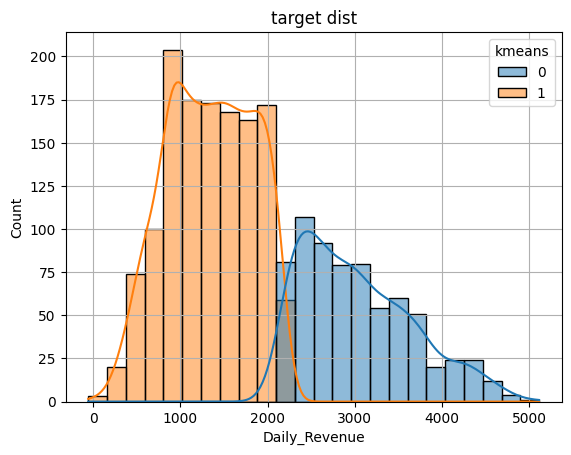

In [18]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [19]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [20]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       461
           1       0.99      1.00      0.99       879

    accuracy                           0.99      1340
   macro avg       0.99      0.99      0.99      1340
weighted avg       0.99      0.99      0.99      1340



In [21]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       228
           1       0.95      0.95      0.95       432

    accuracy                           0.94       660
   macro avg       0.93      0.93      0.93       660
weighted avg       0.94      0.94      0.94       660



### fit regression

In [22]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]

In [23]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape)

train (461, 8) (879, 8)
test (227, 9) (433, 9)


In [24]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

In [25]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target]]),
                             np.hstack([pred_train_0, pred_train_1]),
                              algorithm='segm_kmeans2_regression', dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target]]),
                             np.hstack([pred_test_0, pred_test_1]),
                              algorithm='segm_kmeans2_regression', dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans2_regression, -- Type Dataset - train
R2 = 0.9411332858527828
MSE = 56495.049855249395
RMSE = 237.68687354426916
MAE = 190.76832823276598
MAPE = 0.15505722860348586
segm_kmeans2_regression, -- Type Dataset - test
R2 = 0.9344711605812528
MSE = 61454.30010537161
RMSE = 247.89977834877467
MAE = 198.53970277131396
MAPE = 0.1407578935974405


## fit k-means 3  clusters on target

### clustering

In [26]:
kmeans = KMeans(n_clusters=3, random_state=2025)
kmeans.fit(scaled_df_train[[target]])

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[[target]])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[[target]])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

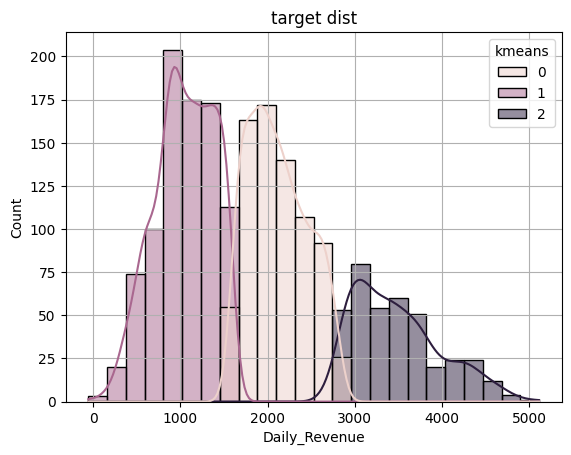

In [27]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [28]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [29]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       509
           1       1.00      1.00      1.00       579
           2       1.00      1.00      1.00       252

    accuracy                           1.00      1340
   macro avg       1.00      1.00      1.00      1340
weighted avg       1.00      1.00      1.00      1340



In [30]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       246
           1       0.91      0.93      0.92       283
           2       0.97      0.85      0.91       131

    accuracy                           0.90       660
   macro avg       0.91      0.89      0.90       660
weighted avg       0.90      0.90      0.90       660



### fit regression

In [31]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]
scaled_df_train_2 = scaled_df_train[scaled_df_train[clf_target] == 2]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]
scaled_df_test_2 = scaled_df_test[scaled_df_test['clf_pred'] == 2]

In [32]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape, scaled_df_train_2.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape, scaled_df_test_2.shape)

train (509, 8) (579, 8) (252, 8)
test (253, 9) (291, 9) (116, 9)


In [33]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

lr_2 = LinearRegression()
lr_2.fit(scaled_df_train_2[linear_features], scaled_df_train_2[target])
pred_train_2 = lr_2.predict(scaled_df_train_2[linear_features])
pred_test_2 = lr_2.predict(scaled_df_test_2[linear_features])

In [34]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target],
                                        scaled_df_train_2[target]]),
                             np.hstack([pred_train_0, pred_train_1, pred_train_2]),
                              algorithm='segm_kmeans3_regression', dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target],
                                        scaled_df_test_2[target]]),
                             np.hstack([pred_test_0, pred_test_1, pred_test_2]),
                              algorithm='segm_kmeans3_regression', dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans3_regression, -- Type Dataset - train
R2 = 0.9561998067982888
MSE = 42035.539683969466
RMSE = 205.02570493469707
MAE = 164.4117555963543
MAPE = 0.1375357985020704
segm_kmeans3_regression, -- Type Dataset - test
R2 = 0.9359616740253188
MSE = 60056.46578821875
RMSE = 245.06420748085338
MAE = 196.53507686691816
MAPE = 0.13242267027675944


## fit 2 clusters on features

### clustering

In [35]:
kmeans = KMeans(n_clusters=2, random_state=2025)
kmeans.fit(scaled_df_train[linear_features])

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[linear_features])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[linear_features])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

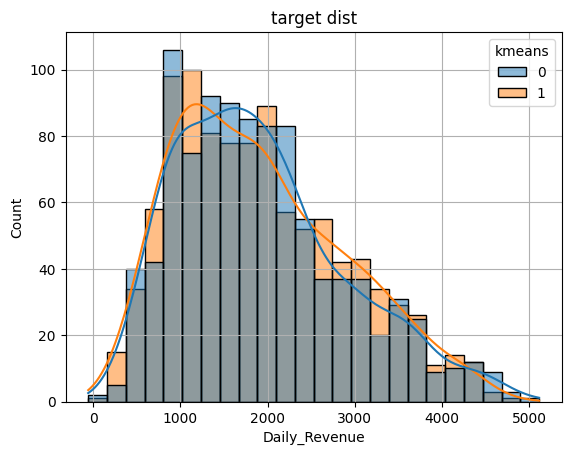

In [36]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [37]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [38]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       657
           1       1.00      1.00      1.00       683

    accuracy                           1.00      1340
   macro avg       1.00      1.00      1.00      1340
weighted avg       1.00      1.00      1.00      1340



In [39]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       332
           1       0.98      0.99      0.99       328

    accuracy                           0.99       660
   macro avg       0.99      0.99      0.99       660
weighted avg       0.99      0.99      0.99       660



### fit regression

In [40]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]

In [41]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape)

train (657, 8) (683, 8)
test (331, 9) (329, 9)


In [42]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

In [43]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target]]),
                             np.hstack([pred_train_0, pred_train_1]),
                              algorithm='segm_kmeans2onFeatures_regression', 
                              dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target]]),
                             np.hstack([pred_test_0, pred_test_1]),
                              algorithm='segm_kmeans2onFeatures_regression', 
                              dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans2onFeatures_regression, -- Type Dataset - train
R2 = 0.8926332578869952
MSE = 103041.07399812556
RMSE = 321.0001152618571
MAE = 251.72547989715153
MAPE = 0.19615249450207095
segm_kmeans2onFeatures_regression, -- Type Dataset - test
R2 = 0.8889269041854357
MSE = 104166.64516521401
RMSE = 322.74857887404244
MAE = 254.7689710006037
MAPE = 0.19556130747064826


## fit 3 clusters on features

### clustering

In [44]:
kmeans = KMeans(n_clusters=3, random_state=2025)
kmeans.fit(scaled_df_train[linear_features])

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[linear_features])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[linear_features])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

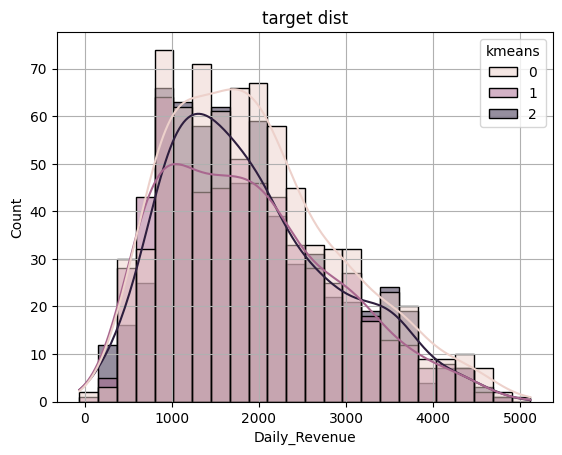

In [45]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [46]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [47]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       520
           1       1.00      1.00      1.00       401
           2       1.00      1.00      1.00       419

    accuracy                           1.00      1340
   macro avg       1.00      1.00      1.00      1340
weighted avg       1.00      1.00      1.00      1340



In [48]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       246
           1       0.97      0.96      0.97       200
           2       0.96      0.97      0.97       214

    accuracy                           0.97       660
   macro avg       0.97      0.97      0.97       660
weighted avg       0.97      0.97      0.97       660



### fit regression

In [49]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]
scaled_df_train_2 = scaled_df_train[scaled_df_train[clf_target] == 2]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]
scaled_df_test_2 = scaled_df_test[scaled_df_test['clf_pred'] == 2]

In [50]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape, scaled_df_train_2.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape, scaled_df_test_2.shape)

train (520, 8) (401, 8) (419, 8)
test (247, 9) (198, 9) (215, 9)


In [51]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

lr_2 = LinearRegression()
lr_2.fit(scaled_df_train_2[linear_features], scaled_df_train_2[target])
pred_train_2 = lr_2.predict(scaled_df_train_2[linear_features])
pred_test_2 = lr_2.predict(scaled_df_test_2[linear_features])

In [52]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target],
                                        scaled_df_train_2[target]]),
                             np.hstack([pred_train_0, pred_train_1, pred_train_2]),
                              algorithm='segm_kmeans3onFeatures_regression',
                               dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target],
                                        scaled_df_test_2[target]]),
                             np.hstack([pred_test_0, pred_test_1, pred_test_2]),
                              algorithm='segm_kmeans3onFeatures_regression',
                               dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans3onFeatures_regression, -- Type Dataset - train
R2 = 0.8937825831756969
MSE = 101938.0535488659
RMSE = 319.2773927932667
MAE = 250.90513520368572
MAPE = 0.19387855167534385
segm_kmeans3onFeatures_regression, -- Type Dataset - test
R2 = 0.88592509281621
MSE = 106981.80591551015
RMSE = 327.0807330239893
MAE = 257.37689345007715
MAPE = 0.19803443866371173


# Catboost

In [53]:
catboost_features = num_features+cat_features

In [56]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

def objective(trial, X, y):
    # Разделение данных на train и validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2025)
    
    # Параметры для перебора
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'boosting_type': 'Plain',
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 255),
        'eval_metric': 'RMSE',  # Метрика для регрессии
        'loss_function': 'RMSE',  # Функция потерь
        'task_type': 'CPU',
        'verbose': False,
        'random_state': 2025,
    }
    
    # Параметры глубины
    if params['grow_policy'] == 'Lossguide':
        params['max_leaves'] = trial.suggest_int('max_leaves', 4, 64)
    elif params['grow_policy'] == 'Depthwise':
        params['max_depth'] = trial.suggest_int('max_depth', 2, 12)
    
    # Указание категориальных признаков (если есть)
    if cat_features:
        params['cat_features'] = cat_features
    
    # Создание и обучение модели
    model = CatBoostRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        verbose=0
    )
    
    # Предсказание на валидации
    y_pred = model.predict(X_val)
    
    # Метрика качества (можно выбрать другую)
    rmse = metrics.mean_squared_error(y_val, y_pred)**0.5
    # Или можно использовать R2: return r2_score(y_val, y_pred)
    return rmse

# Пример использования:
study = optuna.create_study(direction='minimize')  # Для RMSE минимизируем
study.optimize(lambda trial: objective(trial, 
                                     scaled_df_train[catboost_features], 
                                     scaled_df_train[target]), 
                                     n_trials=50)
best_params = study.best_params

[I 2025-04-23 22:01:23,688] A new study created in memory with name: no-name-8bc92dab-97e0-43c9-a895-b41c475c24a6


[I 2025-04-23 22:01:24,420] Trial 0 finished with value: 295.5958747756757 and parameters: {'iterations': 1543, 'learning_rate': 0.0011774367430738592, 'l2_leaf_reg': 0.006947827607712298, 'random_strength': 0.01383665237162382, 'bagging_temperature': 9.627338014183165, 'border_count': 47, 'min_data_in_leaf': 34, 'leaf_estimation_iterations': 1, 'grow_policy': 'SymmetricTree', 'od_type': 'IncToDec', 'od_wait': 34, 'one_hot_max_size': 39}. Best is trial 0 with value: 295.5958747756757.
[I 2025-04-23 22:01:24,474] Trial 1 finished with value: 344.8970234729617 and parameters: {'iterations': 110, 'learning_rate': 0.013322149758247935, 'l2_leaf_reg': 0.0013501532431492108, 'random_strength': 0.003306224858094246, 'bagging_temperature': 9.28486215113581, 'border_count': 127, 'min_data_in_leaf': 85, 'leaf_estimation_iterations': 4, 'grow_policy': 'SymmetricTree', 'od_type': 'Iter', 'od_wait': 31, 'one_hot_max_size': 100}. Best is trial 0 with value: 295.5958747756757.
[I 2025-04-23 22:01:24,

In [60]:
cat_model = cat.CatBoostRegressor(**best_params)
cat_model.fit(df_train[catboost_features], df_train[target])

0:	learn: 949.7412755	total: 1.3ms	remaining: 1.88s
1:	learn: 922.3314136	total: 2.9ms	remaining: 2.1s
2:	learn: 894.5792157	total: 3.83ms	remaining: 1.85s
3:	learn: 870.7693654	total: 5.35ms	remaining: 1.94s
4:	learn: 844.7987225	total: 6.37ms	remaining: 1.84s
5:	learn: 820.7607304	total: 7.18ms	remaining: 1.73s
6:	learn: 797.0128062	total: 7.94ms	remaining: 1.64s
7:	learn: 773.2794269	total: 8.51ms	remaining: 1.53s
8:	learn: 751.0979312	total: 9.13ms	remaining: 1.46s
9:	learn: 728.7387505	total: 9.89ms	remaining: 1.43s
10:	learn: 708.6516036	total: 11.2ms	remaining: 1.46s
11:	learn: 688.7800073	total: 12.3ms	remaining: 1.48s
12:	learn: 669.7318810	total: 13.4ms	remaining: 1.48s
13:	learn: 651.7745335	total: 14.3ms	remaining: 1.47s
14:	learn: 633.3114360	total: 15.4ms	remaining: 1.48s
15:	learn: 616.9396575	total: 16ms	remaining: 1.44s
16:	learn: 601.0653524	total: 16.7ms	remaining: 1.41s
17:	learn: 585.2967235	total: 17.3ms	remaining: 1.38s
18:	learn: 569.0815459	total: 18.2ms	remain

In [63]:
y_train_pred = cat_model.predict(df_train[catboost_features])
y_test_pred = cat_model.predict(df_test[catboost_features])

In [64]:
result_metrics = get_metrics(df_train[target], y_train_pred,
                              algorithm='catboost_regression', dataset_type='train', 
                              res_df=result_metrics)

catboost_regression, -- Type Dataset - train
R2 = 0.9958303406449632
MSE = 4001.669136026482
RMSE = 63.2587475059891
MAE = 48.74672275572765
MAPE = 0.034952412403379304


In [65]:
result_metrics = get_metrics(df_test[target], y_test_pred,
                              algorithm='catboost_regression', dataset_type='test', 
                              res_df=result_metrics)

catboost_regression, -- Type Dataset - test
R2 = 0.9479716400531839
MSE = 48793.27139810743
RMSE = 220.89199034394034
MAE = 179.15108624385832
MAPE = 0.1282908336893902


In [66]:
result_metrics.query('dataset_type == "train"')

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,simple_regression,train,0.892339,103323.184553,321.439239,252.392688,0.196642
0,segm_kmeans2_regression,train,0.941133,56495.049855,237.686874,190.768328,0.155057
0,segm_kmeans3_regression,train,0.956200,42035.539684,205.025705,164.411756,0.137536
0,segm_kmeans2onFeatures_regression,train,0.892633,103041.073998,321.000115,251.725480,0.196152
0,segm_kmeans3onFeatures_regression,train,0.893783,101938.053549,319.277393,250.905135,0.193879
0,catboost_regression,train,0.995830,4001.669136,63.258748,48.746723,0.034952


In [67]:
result_metrics.query('dataset_type == "test"')

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,simple_regression,test,0.889356,103764.343040,322.124732,254.217141,0.194539
0,segm_kmeans2_regression,test,0.934471,61454.300105,247.899778,198.539703,0.140758
0,segm_kmeans3_regression,test,0.935962,60056.465788,245.064207,196.535077,0.132423
0,segm_kmeans2onFeatures_regression,test,0.888927,104166.645165,322.748579,254.768971,0.195561
0,segm_kmeans3onFeatures_regression,test,0.885925,106981.805916,327.080733,257.376893,0.198034
0,catboost_regression,test,0.947972,48793.271398,220.891990,179.151086,0.128291
